# Raport nr 1, Symulacje komputerowe

###  Emil Olszewski, Artur Sadurski  
---  

**Zadanie 1**  
Generator liczb pseudolosowych

In [47]:
using Plots
using Distributions
using HypothesisTests
using BenchmarkTools
using BenchmarkPlots
using Statistics
using StatsPlots
using KernelDensity
using SpecialFunctions
using LinearAlgebra

Poniżej znajduje się implementacja generatora MRG32k3a liczb pseudolosowych z rozkładu jednostajnego na odcinku [0, 1]

In [2]:
function MRG32k3a(
    size, 
    seedx = [1822406609, 1153072917, 1254937013], 
    seedy = [2311980605, 7239483046, 2394024690]
    )

    result = Vector{Float64}(undef, size)

    m1 = 2^32 - 209
    m2 = 2^32 - 22853

    for i in 1:size

        x = mod((1403580seedx[2] - 810728seedx[3]), m1)
        y = mod((527612seedy[1] - 1370589seedy[3]), m2)

        result[i] = ifelse(x > y, (x - y) / (m1 + 1), (x - y + m1) / (m1 + 1))

        # Do generowania realizacji zmiennej losowej potrzebujemy tylko 3 ostatnich 
        # wartości x i y. Tym samym seedx i seedy możemy traktować jako kolejkę, w
        # każdej iteracji odrzucając wartości z końca i dodanie nowo obliczonych 
        # wartości do początku. 
        
        pop!(seedx); pop!(seedy)
        pushfirst!(seedx, x); pushfirst!(seedy, y)

    end

    return result

end

MRG32k3a (generic function with 3 methods)

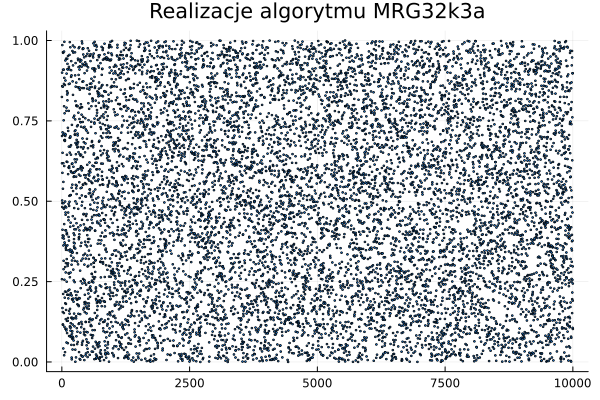

In [3]:
UNIFORM_SAMPLE_SIZE = 10_000
mrg_samples = MRG32k3a(UNIFORM_SAMPLE_SIZE)
scatter(mrg_samples, markersize=1, color=:dodgerblue1, legend=nothing, title="Realizacje algorytmu MRG32k3a")

Jak widać liczby generowane przez *MRG32k3a* rozkładają się w miarę równomiernie na odcinku [0, 1]. Skłania nas to do stwierdzenia, że pochodzą one z rozkładu U(0, 1). Aby potwierdzić tą hipotezę, wykonamy histogram generowanych wartości.

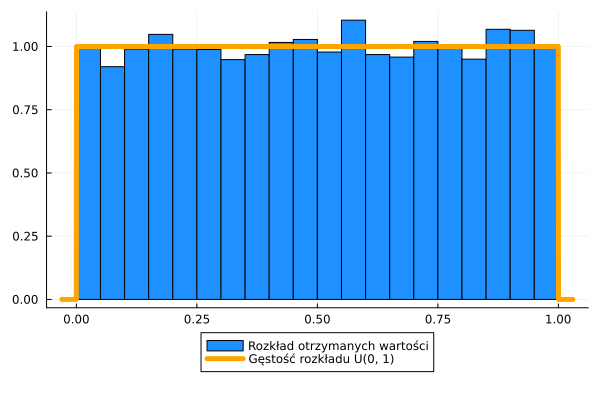

In [4]:
histogram(mrg_samples, color=:dodgerblue1, label="Rozkład otrzymanych wartości", normalize=:pdf, legend=:outerbottom)
plot!(x -> (0 < x < 1), lw=5, color=:orange, label="Gęstość rozkładu U(0, 1)")

Powyższy histogram dobrze obrazuje jednostajność generowanych wartości. Nie dowodzi to jednak niezależności. Sprawdzimy teraz kilka cech, które powinny charakteryzować ciąg niezależnych zmiennych losowych. 

* $Cov(X,Y) = 0$  
   
Jeśli dwie zmienne losowe są niezależne, to $$Cov(X, Y) = E(XY) - E(X)E(Y) = 0$$  
Zauważmy, że implikacja w drugą stronę nie zachodzi, jednakże wytępowanie powyższej równości, może być przesłanką za niezależnością zmiennych.

In [5]:
covariances = ones(100)

for i in 1:100
    seedx1 = rand(Int, 3)
    seedy1 = rand(Int, 3)
    X = MRG32k3a(100_000, rand(Int, 3), rand(Int, 3))
    Y = MRG32k3a(100_000, rand(Int, 3), rand(Int, 3))
    covariances[i] = mean(X .* Y) - mean(X) * mean(Y)
end

mean(abs.(covariances))

0.00020860264459859917

Jak widać, średnia wartość modułu kowariancjii jest bardzo mała, co może świadczyć o niezależności ciągów generowanych przez algorytm *MRG32k3a* z losowym ziarnem.

* Rozkład zmiennej $|X - Y|$
  
Sprawdzimy teraz czy kolejne wartości ciągu generowanego przez algorytm są niezależne względem siebie. Jeśli następujące po sobie wartości *iid* (independent, identically distrubuted), to rozkład $|x[i + 1] - x[i]|$ zadany jest wzorem 

$$ f(x) = 2\,\int_0^\infty g(x + y)g(y)\,dy = 2(1 - x) \quad dla \; x \in [0,1]$$  

gdzie $g(x)$ jest gęstością rozkładu jednostajnego na odcinku [0, 1].  
Powyższe równanie wynika ze wzoru na gęstość różnicy niezależnych zmiennych losowych i gęstość odwzorowania zmiennej losowej przez funkcję mierzalną. 

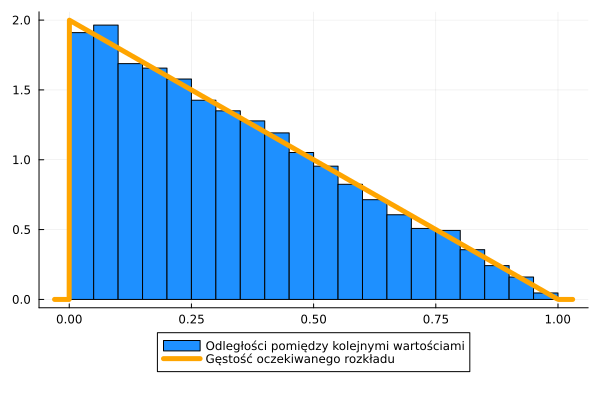

In [6]:
distances = [abs(mrg_samples[i + 1] - mrg_samples[i]) for i in 1:UNIFORM_SAMPLE_SIZE - 1]
histogram(distances, color=:dodgerblue1, label="Odległości pomiędzy kolejnymi wartościami", normalize=:pdf, legend=:outerbottom)
plot!(x -> 2 * (1 - x) * (0 < x < 1), lw = 5, color=:orange, label="Gęstość oczekiwanego rozkładu")

Jak widać histogram odległości między wartościami pasuje do wyznaczonego wcześniej rozkładu. Jest to kolejna przesłanka za tym, że algorytm generuje wartości *iid*. 

Na sam koniec porównamy wydajność naszego algorytmu do wbudowanej funkcji *rand*

In [7]:
@benchmark MRG32k3a(UNIFORM_SAMPLE_SIZE)

BenchmarkTools.Trial: 5802 samples with 1 evaluation.
 Range (min … max):  347.500 μs …  18.622 ms  ┊ GC (min … max): 0.00% … 95.66%
 Time  (median):     724.750 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   834.379 μs ± 611.956 μs  ┊ GC (mean ± σ):  1.56% ±  2.78%

  ▆▅▁▃▆▅█▆▄▆▆▅▅▄▂▂▂▁▁ ▁                                          
  █████████████████████▇▆▆▆▆▅▆▅▄▄▄▅▄▄▃▃▃▃▃▃▃▂▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂ ▅
  348 μs           Histogram: frequency by time          2.3 ms <

 Memory estimate: 78.48 KiB, allocs estimate: 6.

In [8]:
@benchmark rand(UNIFORM_SAMPLE_SIZE)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  17.000 μs …  27.990 ms  ┊ GC (min … max):  0.00% … 99.65%
 Time  (median):     53.900 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   80.462 μs ± 492.690 μs  ┊ GC (mean ± σ):  16.14% ±  2.95%

   ▇▁▁▃█▆▅▅▆▂                                                   
  ▆███████████▇▆▅▄▄▄▄▄▄▄▅▅▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  17 μs           Histogram: frequency by time          268 μs <

 Memory estimate: 78.17 KiB, allocs estimate: 2.

---

**Zadanie 2**

Generowanie rozkładu Poissona z rozkładu geometrycznego metodą akceptacji odrzucenia. 

In [9]:
poisson_param = 4
geometric_param = 1/5

0.2

In [10]:
poisson(n) = exp(-poisson_param) * poisson_param^n / factorial(big(n))
geometric(n) = (1 - geometric_param)^n * geometric_param

geometric (generic function with 1 method)

In [11]:
c = maximum(poisson(n) / geometric(n) for n in 1:10)

2.384848813637262248383334454043514174124706526420921931229070944256910429959262

In [12]:
function accept_reject()

    x = rand(Geometric(geometric_param))

    while c * rand() * geometric(x) > poisson(x)
        x = rand(Geometric(geometric_param))
    end

    return x

end


function accept_reject_vectorized(size)

    result = zeros(Int64, size)

    for i in 1:size

        x = rand(Geometric(geometric_param))
        
        while c * rand() * geometric(x) > poisson(x)
            x = rand(Geometric(geometric_param))
        end

        result[i] = x

    end

    return result

end

accept_reject_vectorized (generic function with 1 method)

In [13]:
@benchmark [accept_reject() for _ in 1:10_000]

BenchmarkTools.Trial: 48 samples with 1 evaluation.
 Range (min … max):   71.414 ms … 216.294 ms  ┊ GC (min … max): 0.00% … 17.86%
 Time  (median):      98.544 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   105.401 ms ±  28.014 ms  ┊ GC (mean ± σ):  5.33% ±  8.49%

     █ ▅▂   ▂▂               ▅                                   
  ▅▁▅█▅████▅████▅██▁▁▅█▁▅▅▁▁▁█▁▁▁▁▅▅▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅ ▁
  71.4 ms          Histogram: frequency by time          216 ms <

 Memory estimate: 16.01 MiB, allocs estimate: 496939.

In [14]:
@benchmark accept_reject_vectorized(10_000)

BenchmarkTools.Trial: 44 samples with 1 evaluation.
 Range (min … max):   75.574 ms … 190.227 ms  ┊ GC (min … max): 0.00% … 17.81%
 Time  (median):     106.393 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   115.668 ms ±  29.270 ms  ┊ GC (mean ± σ):  4.44% ±  7.20%

       ▁  █  ▄ ▁ ▄ ▁ ▁  ▁  ▁   ▁                           ▁     
  ▆▁▆▁▆█▆▆█▆▆█▆█▁█▁█▁█▁▁█▁▁█▁▆▆█▁▆▆▁▆▁▁▆▁▁▁▁▁▁▆▆▁▆▁▁▁▁▁▁▁▁▁█▁▁▆ ▁
  75.6 ms          Histogram: frequency by time          190 ms <

 Memory estimate: 16.25 MiB, allocs estimate: 509522.

In [15]:
samples =  accept_reject_vectorized(100_000)

100000-element Vector{Int64}:
 6
 3
 1
 4
 6
 4
 7
 3
 3
 4
 ⋮
 5
 4
 3
 2
 3
 5
 9
 1
 1

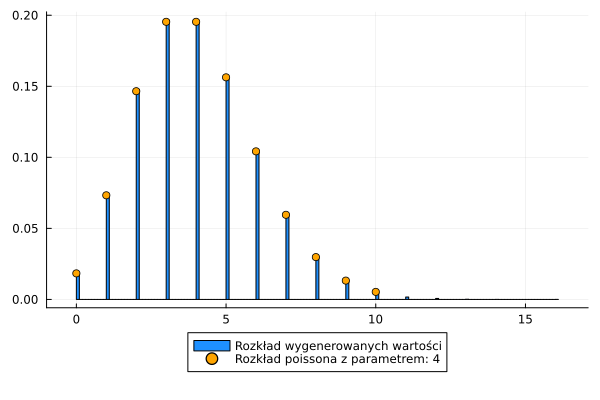

In [16]:
histogram(samples, normalize=:probability, color=:dodgerblue1, label="Rozkład wygenerowanych wartości", legend=:outerbottom)
scatter!(0:10, pdf.(Poisson(poisson_param), 0:10), color=:orange, label="Rozkład poissona z parametrem: $(poisson_param)")

---  

**Zadanie 3**  

Generowanie rozkładu normalnego z rozkładu wykładniczego metodą zigguratu.

In [17]:
function findindex(x, interval)
    i = 1
    while x > interval[i] && i < length(interval)
        i += 1
    end
    i
end

findindex (generic function with 1 method)

In [18]:
function steps(resolution :: Int)

    # Ze względu na to, że gęstość |N(0, 1)| jest ściśle malejąca na swojej dziedzinie, to maksimum będzie się znajdować 
    # na początku przedziału a minimum na końcu przedziału 

    # Minimum z przedziału [xᵢ, xᵢ₊₁] jest maksimum z przedziału [xᵢ₊₁, xᵢ₊₂]

    xs = LinRange(0, 5, resolution)

    ys = 2 .* pdf.(Normal(0, 1), xs)
    push!(ys, 0)

    return (xs, ys)

end

steps (generic function with 1 method)

In [19]:
function ziggurat(N, intervals, extr)

    samples = Vector{Float64}(undef, N)
    counts = 0

    for i = 1:N
        x = 0.
        counter = 0
        num_of_runs = 0
        
        while true 
         
            x = rand(Exponential(1))
            y = sqrt(2ℯ/π) * rand() * pdf(Exponential(1), x)
            idx = findindex(x, intervals)
            num_of_runs += 1
            
            # Jeśli y jest większy niż maksimum na danym przedziale, to odrzucamy wylosowaną wartość.
            if y > extr[idx] 
                continue
            end

            # Jeśli mniejszy niż minimum to akceptujemy.
            if y < extr[idx + 1]
                break
            end

            # Tylko gdy oba powyższe warunki nie są spełnione to obliczamy gęstość rozkładu normalnego.
            if y <= 2 * pdf(Normal(0, 1), x)
                counter += 1
                break
            end

        end

        samples[i] = x
        
        # Częstość wywoływania gęstości rozkładu normalnego.
        counts += counter / num_of_runs
    end

    return (samples, counts/N)

end

ziggurat (generic function with 1 method)

In [20]:
function accept_reject(N)
    
    result = Vector{Float64}(undef, N)

    for i in 1:N
        x = rand(Exponential(1))
        y = sqrt(2ℯ/π) * rand() * pdf(Exponential(1), x)
        while y > 2 * pdf(Normal(0, 1), x)
            x = rand(Exponential(1))
            y = sqrt(2ℯ/π) * rand() * pdf(Exponential(1), x)
        end
        result[i] = x
    end

    return result
end

accept_reject (generic function with 2 methods)

In [21]:
intervals, extr = steps(100)

(LinRange{Float64}(0.0, 5.0, 100), [0.7978845608028654, 0.7968676033826929, 0.793824501598896, 0.7887784680098376, 0.7817678623999035, 0.7728457061791374, 0.7620790146369437, 0.7495479588127804, 0.7353448716447151, 0.7195731156252466  …  2.066201316264341e-5, 1.6361031018778815e-5, 1.292233278529759e-5, 1.0180366030943498e-5, 7.999780744833251e-6, 6.270251981824024e-6, 4.902122085884661e-6, 3.822746249407833e-6, 2.9734390294685954e-6, 0.0])

In [22]:
@benchmark ziggurat(1_000_000, intervals, extr)

BenchmarkTools.Trial: 32 samples with 1 evaluation.
 Range (min … max):  134.409 ms … 223.489 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     150.975 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   159.031 ms ±  20.355 ms  ┊ GC (mean ± σ):  0.49% ± 1.76%

  ▁   ▄ ▁   █▁ ▁  ▁                  ▁                           
  █▁▁▁█▆█▆▆▆██▁█▁▁█▆▁▁▆▁▁▁▁▆▆▆▆▁▁▆▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▆ ▁
  134 ms           Histogram: frequency by time          223 ms <

 Memory estimate: 7.63 MiB, allocs estimate: 3.

In [23]:
@benchmark accept_reject(1_000_000)

BenchmarkTools.Trial: 69 samples with 1 evaluation.
 Range (min … max):  58.520 ms … 157.788 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     69.459 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   72.409 ms ±  12.805 ms  ┊ GC (mean ± σ):  1.20% ± 4.04%

                     ▂   █                                      
  ▆▆▄▁▄▄▁▄▄▁▄▁█▆▆▁▆▄▁██▄▆█▁▁▄█▄▄▆▄▄▁█▁▁▄▁▄▄▁▄█▄▁▁▄▁▆▁▄▄▁▁▁▄▄▁█ ▁
  58.5 ms         Histogram: frequency by time         86.6 ms <

 Memory estimate: 7.63 MiB, allocs estimate: 2.

Zwróćmy teraz uwagę na fakt, że funkcja `ziggurat` generuje wartości z rozkładu $|N(0, 1)|$. Rozkład $ N(0, 1)$ uzyskamy łącząc uzyskany wektor z wektorem do niego przeciwnym. Tym samym w celu uzyskania próby o długości $ n$ wystarczy wysymulować tylko próbę o długości $\frac{n}{2}$.  

In [24]:
@benchmark ziggurat(500_000, intervals, extr)

BenchmarkTools.Trial: 65 samples with 1 evaluation.
 Range (min … max):  61.654 ms … 158.958 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     74.030 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   77.468 ms ±  15.204 ms  ┊ GC (mean ± σ):  0.39% ± 2.23%

      █  ▄  ▂  ▂ ▄                                              
  ▆▄▆▁█████▄█▆▁███▄▁▆█▁▄█▆▁▄▁▁▁▄▁▁▁▁▆▁▁▁▄▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  61.7 ms         Histogram: frequency by time          124 ms <

 Memory estimate: 3.81 MiB, allocs estimate: 3.

In [25]:
abs_norm_samples, mean_pdf_calls_rate = ziggurat(10000, intervals, extr)
mean_pdf_calls_rate

0.034914999999999995

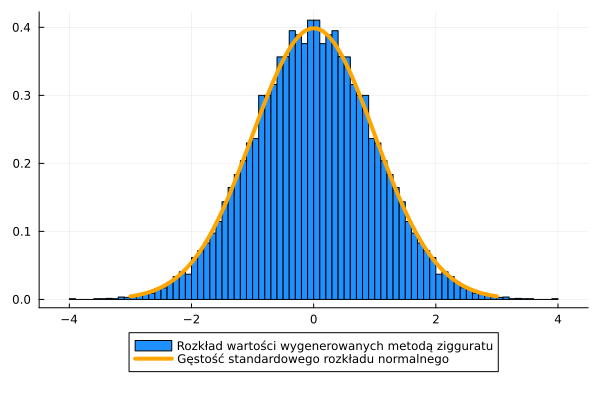

In [26]:
samples = vcat(abs_norm_samples, -abs_norm_samples)
xs = LinRange(-3, 3, 60)
kern = kde(samples)

histogram(samples, normalize=:pdf, label="Rozkład wartości wygenerowanych metodą zigguratu", color=:dodgerblue1, legend=:outerbottom)
plot!(xs, pdf.(Normal(0, 1), xs), label="Gęstość standardowego rozkładu normalnego", lw=4, color=:orange)

In [27]:
ExactOneSampleKSTest(samples, Normal(0, 1))

Exact one sample Kolmogorov-Smirnov test
----------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.00467441

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.7747

Details:
    number of observations:   20000


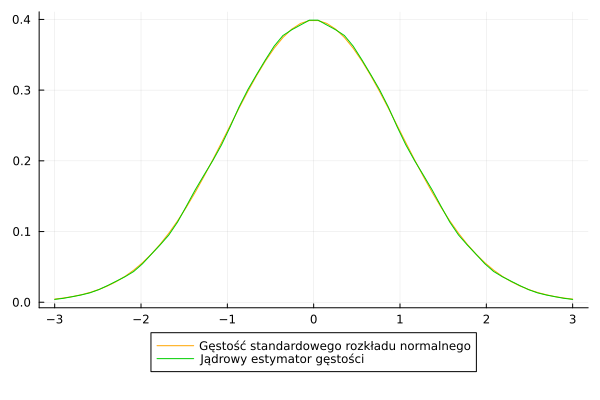

In [28]:
plot(xs, pdf.(Normal(0, 1), xs), label="Gęstość standardowego rozkładu normalnego", color=:orange, legend=:outerbottom)
plot!(xs, pdf(kern, xs), label="Jądrowy estymator gęstości", color=:green3)

---

**Zadanie 4**   

Porównanie różnych metod generowania rozkładu normalnego

In [29]:
SAMPLESIZE = 100_000

100000

* Metoda wbudowana `randn`

In [30]:
@benchmark randn(SAMPLESIZE)

BenchmarkTools.Trial: 6587 samples with 1 evaluation.
 Range (min … max):  266.700 μs …  33.825 ms  ┊ GC (min … max): 0.00% … 96.63%
 Time  (median):     623.100 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   730.126 μs ± 880.729 μs  ┊ GC (mean ± σ):  8.23% ±  8.30%

  ▂█▁  ▄                                                         
  ███▇███▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂ ▃
  267 μs           Histogram: frequency by time         4.82 ms <

 Memory estimate: 781.30 KiB, allocs estimate: 2.

In [31]:
builtin_sample = randn(SAMPLESIZE)
ExactOneSampleKSTest(builtin_sample, Normal(0, 1))

Exact one sample Kolmogorov-Smirnov test
----------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.002371

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.6275

Details:
    number of observations:   100000


* Metoda odwrotnej dystrybuanty 

Dystrybuanta standardowego rozkładu normalnego $\Phi$ zadana jest wzorem

$$\Phi(x) = \frac{1}{2}\,\mathit{erfc}(-\frac{x}{\sqrt{2}})$$ 

gdzie $\mathit{erfc}(x) = \frac{2}{\sqrt{\pi}}\,\int_x^\infty e^{-t^2}\,dt$.  
W związku z tym 

$$\Phi^{-1}(x) = -\sqrt{2}\,\mathit{erfc}^{-1}(2x)$$

Do obliczenia odwrotnej dystrybuanty standardowego rozkładu normalnego skorzystamy z funkcji `erfcinv` z pakietu `SpecialFunctions`.

In [32]:
inversecdf(x) = -sqrt(2) * erfcinv(2x)

inversecdf (generic function with 1 method)

In [33]:
function inv(size)
    return inversecdf.(rand(size))
end

inv (generic function with 1 method)

In [34]:
@benchmark inv(SAMPLESIZE)

BenchmarkTools.Trial: 1011 samples with 1 evaluation.
 Range (min … max):  2.634 ms … 14.097 ms  ┊ GC (min … max): 0.00% … 57.61%
 Time  (median):     4.550 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.909 ms ±  1.514 ms  ┊ GC (mean ± σ):  2.05% ±  7.00%

       █▅▁▁█▃▁▄▁ ▁  ▂                                         
  ▄▃▃▃▇███████████▇███▇▇▆▆▆▆▄▄▃▄▃▃▃▃▃▃▂▃▁▁▂▃▂▂▁▁▂▂▁▂▁▂▂▃▁▁▂▂ ▄
  2.63 ms        Histogram: frequency by time        11.2 ms <

 Memory estimate: 1.53 MiB, allocs estimate: 4.

In [35]:
inversecdf_samples = inv(SAMPLESIZE)
ExactOneSampleKSTest(inversecdf_samples, Normal(0, 1))

Exact one sample Kolmogorov-Smirnov test
----------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.00260148

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.5078

Details:
    number of observations:   100000


* Metoda Boxa - Mullera 

W tej metodzie skorzystamy z następującego faktu.  
$$\frac{1}{2}R^2 \sim \mathit{Exp}(1) \wedge \Theta \sim U(0, 2\pi) \implies R\sin(\Theta) \sim N(0, 1)$$

In [36]:
function boxmuller(size)

    θ = 2π .* rand(size)
    R = sqrt.(2 .* rand(Exponential(1), size))

    return R .* sin.(θ)
end

boxmuller (generic function with 1 method)

In [37]:
@benchmark boxmuller(SAMPLESIZE)

BenchmarkTools.Trial: 980 samples with 1 evaluation.
 Range (min … max):  2.443 ms … 17.963 ms  ┊ GC (min … max): 0.00% … 42.54%
 Time  (median):     4.579 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.052 ms ±  2.073 ms  ┊ GC (mean ± σ):  5.67% ± 11.94%

    ▁▄▅▅▆▇█▅▅▃▄▅▂▁▁▁▁                                         
  ▆▇███████████████████▇▇▃▆▆▅▃▄▃▃▃▃▃▃▃▁▂▂▂▂▂▃▂▂▂▂▂▂▃▂▁▃▂▂▂▂▂ ▄
  2.44 ms        Histogram: frequency by time        13.1 ms <

 Memory estimate: 3.81 MiB, allocs estimate: 10.

In [38]:
boxmuller_samples = boxmuller(SAMPLESIZE)
ExactOneSampleKSTest(boxmuller_samples, Normal(0, 1))

Exact one sample Kolmogorov-Smirnov test
----------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.00236392

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.6313

Details:
    number of observations:   100000


* Metoda Marsaglii

Metoda Marsaglii jest modyfikacją algorytmu Boxa-Mullera, w której zamiast obliczać wartość sinusa wbudowaną funkcją `sin`, generujemy punkt z koła jednostkowego i używamy jego współrzędnych.  

In [39]:

function marsaglia(size)

    result = Vector{Float64}(undef, size)

    for i in 1:size
        
        # Punkt z rozkładu jednostajnego na kwadracie [-1, 1]²
        x = 2 * rand() - 1
        y = 2 * rand() - 1

        # Powtarzaj dopóki wylosowany punkt nie znajduje się wewnątrz koła.
        while x^2 + y^2 > 1
            x = 2 * rand() - 1
            y = 2 * rand() - 1
        end

        s = x^2 + y^2

        result[i] = x * sqrt(-2log(s) / s)
    end

    return result
end

marsaglia (generic function with 1 method)

In [40]:
@benchmark marsaglia(SAMPLESIZE)

BenchmarkTools.Trial: 1163 samples with 1 evaluation.
 Range (min … max):  2.746 ms …  11.187 ms  ┊ GC (min … max): 0.00% … 43.37%
 Time  (median):     4.101 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.260 ms ± 944.441 μs  ┊ GC (mean ± σ):  0.90% ±  4.70%

       ▁     ▁▁█▇▅▄▄▃▃▁ ▃▁ ▁▁▂▁                                
  ▄▆█▆███▇▆█▇██████████▇███████▇██▇▇▆▆▆▅▅▄▃▅▃▄▃▄▃▄▂▂▂▂▂▁▃▁▂▂▂ ▅
  2.75 ms         Histogram: frequency by time        6.93 ms <

 Memory estimate: 781.30 KiB, allocs estimate: 2.

Porównamy teraz wydajność czterech przedstawionych wyżej metod

In [43]:
function benchmark(size)
    
    suite = BenchmarkGroup()
    for f in (boxmuller, marsaglia, randn, inv)
        suite[string(f)] = @benchmarkable $(f)($size)
    end
    tune!(suite)
    run(suite, samples=50)

end

benchmark (generic function with 1 method)

In [45]:
bench_results = benchmark(SAMPLESIZE)

4-element BenchmarkTools.BenchmarkGroup:
  tags: []
  "randn" => Trial(274.900 μs)
  "marsaglia" => Trial(2.727 ms)
  "boxmuller" => Trial(2.359 ms)
  "inv" => Trial(2.506 ms)

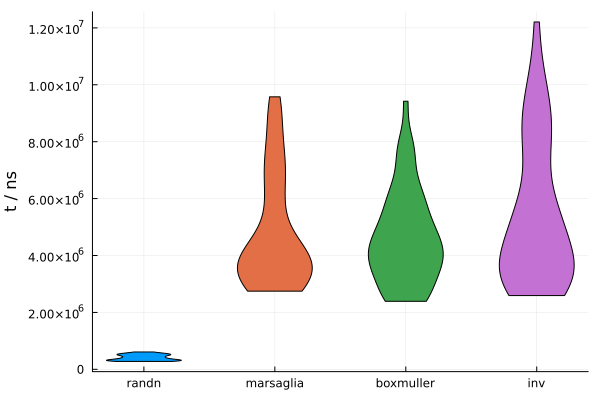

In [48]:
plot(bench_results)